# **PGM homework**

# 1 - Gaussian processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal

## 1. Learning

In [2]:
class GaussianProcess(nn.Module):
    def __init__(self):
        super().__init__()
        self.gp_params = nn.Parameter(torch.randn(5), requires_grad=True)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.X_train = None
        self.Y_train = None
        self.cov = None
    
    def kernel(self, X, Y):
        return self.gp_params[0]**2 * torch.exp(- torch.cdist(X, Y) / (2 *  self.gp_params[1]**2)) \
                    +  self.gp_params[2]**2 +  self.gp_params[3]**2 * X @ Y.T

    def fit(self, X_train, Y_train, nb_epoch):
        self.train()
        self.X_train = X_train
        self.Y_train = Y_train
        losses= []
        for epoch in range(nb_epoch):
            self.optimizer.zero_grad()
            
            kXX = self.kernel(self.X_train, self.X_train)
            cov = kXX + self.gp_params[4]**2 * torch.eye(kXX.shape[-1])
            self.cov = cov.detach()
            mvn = MultivariateNormal(torch.zeros(cov.shape[-1]), covariance_matrix=cov)
            loss = - mvn.log_prob(self.Y_train)

            losses.append(loss.detach())
            loss.backward()
            self.optimizer.step()
        return losses

## 2. Prediction

In [3]:
@torch.no_grad()
def predict(self, X_new):
    self.eval()
    kXx = self.kernel(self.X_train, X_new)
    kxx = self.kernel(X_new, X_new).diag()
    c = kxx + self.gp_params[4]**2
    inv_cov = torch.linalg.inv(self.cov)
    posterior_mean = kXx.T @ inv_cov @ self.Y_train
    posterior_std = torch.sqrt(c - (kXx.T @ inv_cov * kXx.T).sum(axis=-1))
    return posterior_mean, posterior_std

GaussianProcess.predict = predict

## 3. Real data

In [4]:
import pandas as pd
data = pd.read_csv("./UScrimes.csv", sep=",")
data[:5]

,Unnamed: 0,Murder,Assault,UrbanPop
0,Alabama,13.2,236,58
1,Alaska,10.0,263,48
2,Arizona,8.1,294,80
3,Arkansas,8.8,190,50
4,California,9.0,276,91


In [5]:
from sklearn.model_selection import train_test_split
X_data, Y_data = np.array(data.iloc[:,2:4]), np.array(data.iloc[:,1])
dataset_split = train_test_split(X_data, Y_data, test_size=0.25, random_state=42)
X_train, X_test, Y_train, Y_test = [torch.from_numpy(dataset).float() for dataset in dataset_split]
print("Shapes are:", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Shapes are: torch.Size([37, 2]) torch.Size([13, 2]) torch.Size([37]) torch.Size([13])


In [10]:
%%time
nb_epoch = 500
gp = GaussianProcess()
losses = gp.fit(X_train, Y_train, nb_epoch)

Wall time: 639 ms


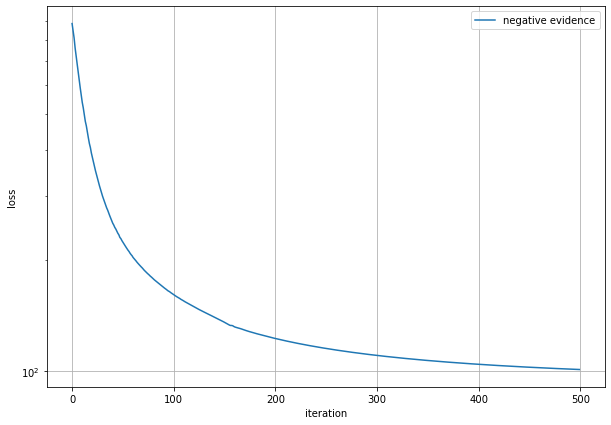

In [11]:
plt.figure(figsize=(10,7))
plt.semilogy(losses, label="negative evidence")
plt.xlabel("iteration"), plt.ylabel("loss")
plt.legend(), plt.grid(), plt.show();

In [12]:
post_mean, post_std = gp.predict(X_test)

from sklearn.linear_model import LinearRegression
ols = LinearRegression().fit(X_train, Y_train)
Y_ols = ols.predict(X_test)

from sklearn.metrics import mean_squared_error
gp_mse = mean_squared_error(Y_test, post_mean)**0.5
ols_mse = mean_squared_error(Y_test, Y_ols)**0.5

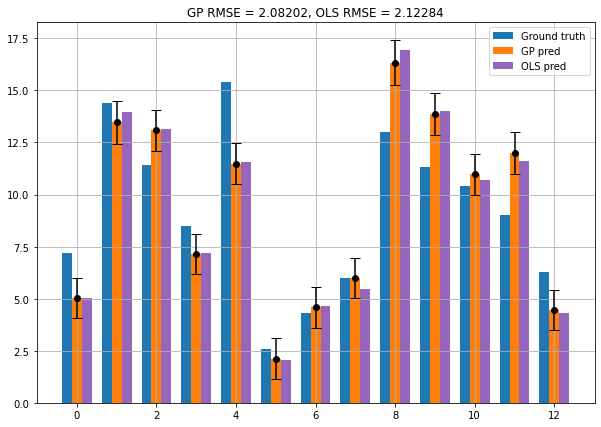

In [13]:
width = 0.25
plt.figure(figsize=(10,7))
plt.bar(np.arange(len(post_mean))-width, Y_test, width=width, label="Ground truth")
plt.bar(np.arange(len(post_mean)), post_mean, width=width, label="GP pred")
plt.errorbar(np.arange(len(post_mean)), post_mean, yerr=post_std/2, fmt="o", capsize = 5, color="k")
plt.bar(np.arange(len(post_mean))+width, Y_ols, width=width, color="C4", label="OLS pred")
plt.title(f"GP RMSE = {gp_mse:.5f}, OLS RMSE = {ols_mse:.5f}")
plt.legend(), plt.grid(), plt.show();

Yeah, we decreased RMSE 💪

# 2 - IWAE for binarised MNIST

In this assignment, you'll play a bit with a VAE on a binarised version of MNIST

## Loading useful stuff

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

## Loading MNIST and binarising it

In [ ]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test = tf.cast(y_test, tf.int64)

11501568/11490434 [==============================] - 0s 0us/step


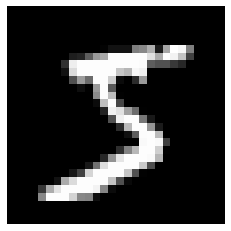

In [ ]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

Then we binarise the data. There are many ways to do that. Here, we simply round the numbers, following the [TF tutorial on convolutional VAEs](https://www.tensorflow.org/tutorials/generative/cvae).

In [ ]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

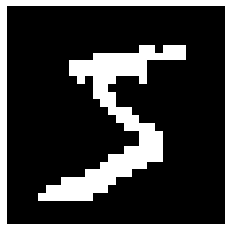

In [ ]:
plt.imshow(train_images[0].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

# Specifying our graphical model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net. This neural net will be defined as a keras sequential model.

In [ ]:
d = 64 # dimension of the latent space

rv_Z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

In [ ]:
h = 128 # number of hidden units

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[None, d]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(28*28)
])

Note that the decoder needs to output probabilities, which can be constrained using a sigmoid final layer. However, it is generally better (i.e. computationnaly more stable) to work with [logits](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop) than probabilities, when doing deep learning. For instance, all the distributions of TensorFlow probability or Pytorch distributions that use probabilities as parameters (e.g. [Bernoulli](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli), [categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) or [binomial](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Binomial)) can use $\texttt{logits}$ or $\texttt{probs}$ as arguments. It is generally better to use  $\texttt{logits}$. This is why this keras model for the decoder does not output probabilities, but logits.





**1. Implement a function that performs ancestral sampling for this deep latent variable model, and show 5 sampled images from the initialised model. Of course, we expect these samples to look like random noise, since we have not trained our model yet.**

In [ ]:
def ancestral_sampling(nb_images):
    Z = rv_Z.sample(nb_images)
    logit_x = decoder(Z) # log-odds of p(X=1|Z)
    out = tfd.Bernoulli(logits=logit_x).sample()
    return out

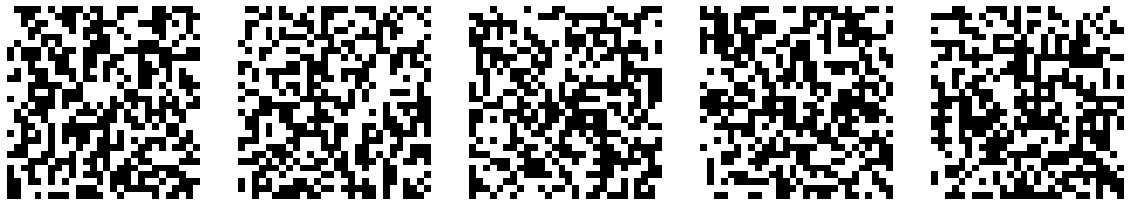

In [ ]:
sampled_images = ancestral_sampling(5) 
plt.figure(figsize=(20,7))
for i, image in enumerate(sampled_images):
    plt.subplot(1,5,i+1)
    plt.imshow(tf.reshape(image,(28,28)), cmap='gray')
    plt.axis('off')
plt.show()

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [ ]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(2*d) # 2*d because we need both the mean and the diagonal of the covariance of q(z|x)
])

##The IWAE objective

The **IWAE objective** is defined as
$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_{ik}){p(\mathbf{z}_{ik})}}{{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}_i)}} \right]
$$

**2. Create a function that computes an unbiased estimate of the IWAE bound, and optimise it to train the model. You are allowed to use TF probability to avoid implementing the reparametrisation trick, and you are allowed to use keras for training.** 







In [ ]:
def compute_loss(X, K):
    mean_logvar = encoder(X) # mean and logvar of p(Z|X)
    mean, logvar = mean_logvar[...,:d], mean_logvar[...,d:]
    std = tf.exp(logvar * .5)
    rv_Z_X = tfd.Independent(tfd.Normal(loc=mean, scale=std),reinterpreted_batch_ndims=1)
    Z = rv_Z_X.sample(K)
    # Z = rv_Z.sample((K, len(X))) * std + mean

    logp_z = rv_Z.log_prob(Z)
    logq_z_x = rv_Z_X.log_prob(Z) 
    logit_x = decoder(Z) # log-odds of p(X=1|Z)
    logp_x_z = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logit_x, labels=tf.broadcast_to(X, (K,*X.shape)) ), axis=-1) # logproba of Bernoulli

    loss = tfp.math.reduce_logmeanexp(logp_x_z + logp_z - logq_z_x, axis=0)
    loss = -tf.reduce_mean(loss, axis=0)
    return loss

In [ ]:
def train_step(X, K, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(X, K)
    params2train = (*encoder.trainable_variables, *decoder.trainable_variables)
    gradients = tape.gradient(loss, params2train)
    optimizer.apply_gradients(zip(gradients, params2train ))
    return tf.stop_gradient(loss)

In [ ]:
train_batch_size = 128
test_batch_size = 32
nb_epochs = 30
K = 30

train_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_images, dtype=tf.float32))
test_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_images, dtype=tf.float32))
optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
losses = []
val_losses = []

for epoch in range(nb_epochs):
    print("epoch", epoch)       
    for train_batch, test_batch in zip(train_ds.batch(train_batch_size), test_ds.batch(test_batch_size)):
        loss = train_step(train_batch, K, optimizer)
        losses.append(loss)
        val_loss = tf.stop_gradient(compute_loss(test_batch, K))
        val_losses.append(val_loss)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29


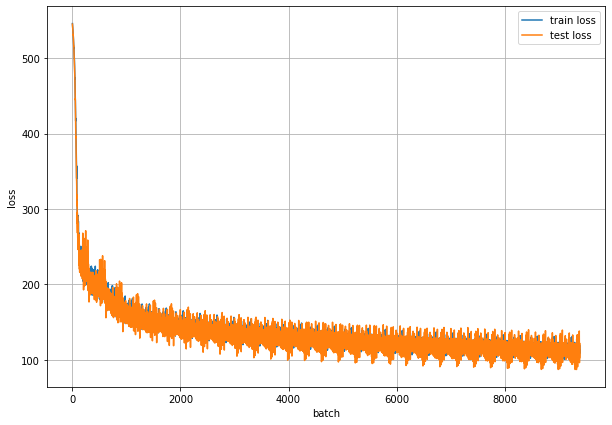

(None, None)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="test loss")
plt.xlabel("batch"), plt.ylabel("loss"), plt.legend(),
plt.grid(), plt.show();

**3. Show a few samples from the model after training.**

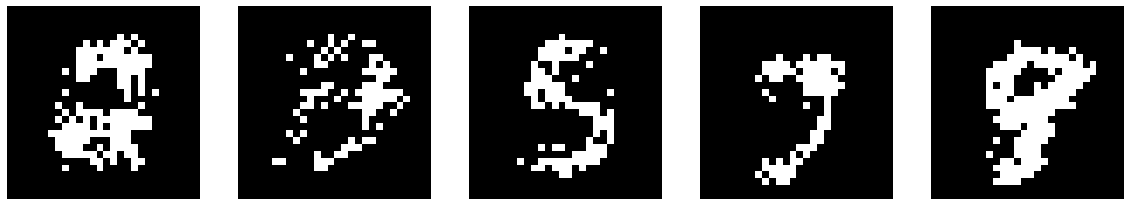

In [ ]:
nb_samples = 5
sampled_images = ancestral_sampling(nb_samples) 
plt.figure(figsize=(20,7))
for i, image in enumerate(sampled_images):
    plt.subplot(1,nb_samples,i+1)
    plt.imshow(tf.reshape(image,(28,28)), cmap='gray')
    plt.axis('off')
plt.show()

**4. Importance sampling and visualisation**

Implement a importance sampling estimate to approximate the posterior mean of each data point:
$$
\mathbb{E}\left[\mathbf{z} \mid \mathbf{x}_{i}\right]=\int \mathbf{z} p\left(\mathbf{z} \mid \mathbf{x}_{i}\right) d \mathbf{z} .
$$
Visualise these two-dimensional embeddings using a scatter plot.

In [ ]:
def posterior_mean(X, K):
    mean_logvar = tf.stop_gradient(encoder(X)) # mean and logvar of p(Z|X)
    mean, logvar = mean_logvar[...,:d], mean_logvar[...,d:]
    std = tf.exp(logvar * .5)
    rv_Z_X = tfd.Independent(tfd.Normal(loc=mean, scale=std),reinterpreted_batch_ndims=1)
    Z = rv_Z_X.sample(K)
    return tf.reduce_mean(Z, axis=0)

In [ ]:
from sklearn.manifold import TSNE

nb_points = 10000
nb_samples = 100
features = train_images[:nb_points]
label = y_train[:nb_points]
E_z = posterior_mean(tf.convert_to_tensor(features, dtype=tf.float32), nb_samples)
E_z_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(E_z)

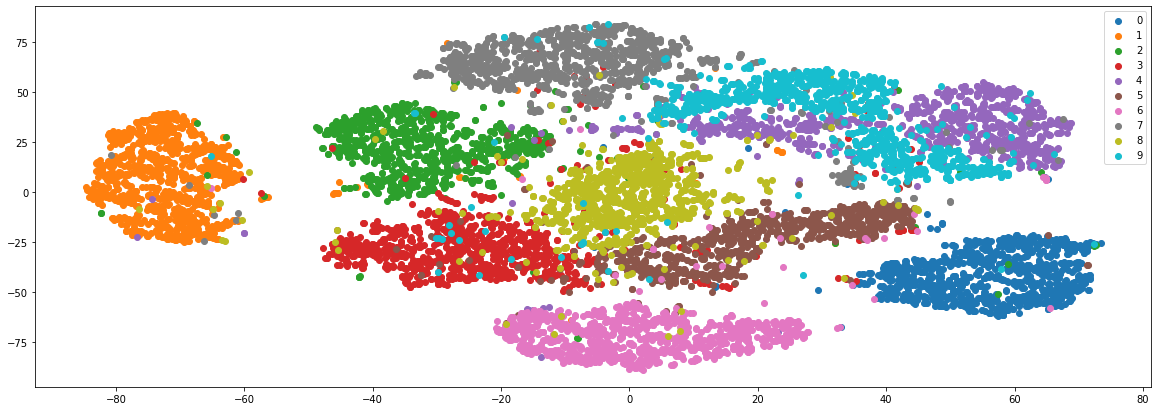

In [ ]:
plt.figure(figsize=(20,7))
for i in range(10):
    plt.scatter(E_z_embedded[label==i][:,0], E_z_embedded[label==i][:,1], label=i)
# plt.axis("off"),
plt.legend(), plt.show();